# Movie Recommendation System Project

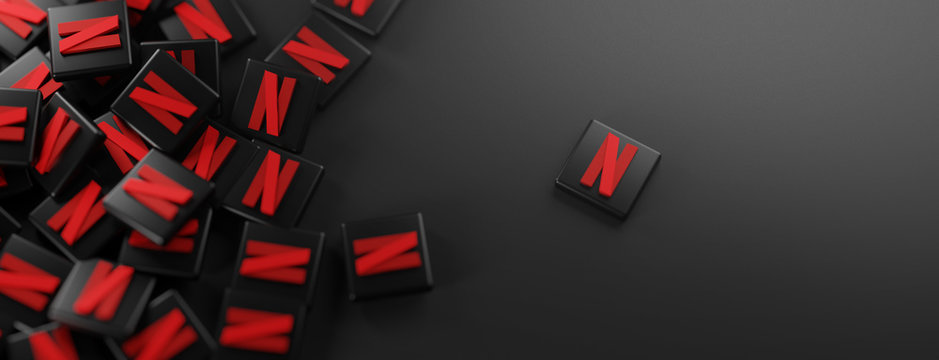

## Overview

The goal to be achieved in this project is to build a quantitative model to generate Top 5 movie recommendations for any user. The data we used includes roughly 100,000 ratings across 610 unique users. We utilized collaboratibe system so the model would make its prediction based on user's ratings on other movies. We are presenting our final product to Netflix Recommendation Solution Team lead by tech supervisor and CTO who oversee the application of algorithm in Netflix recommendation system.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [1]:
import pandas as pd

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate,GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly,\
                                            NormalPredictor, KNNBasic
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import surprise
from surprise.prediction_algorithms import *
from surprise import Dataset, Reader, accuracy
from surprise import SVD
from surprise import dataset

from surprise.model_selection import cross_validate,GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly,\
                                            NormalPredictor, KNNBasic
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier

    
import matplotlib.pyplot as plt
import seaborn as sns
# from pandas_profiling import ProfileReport
from collections import defaultdict

# from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, make_scorer, ConfusionMatrixDisplay, confusion_matrix

## EDA


In [3]:
link_df = pd.read_csv('data/links.csv')
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')

In [4]:
link_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### Data Cleaning

In [8]:
movies_df.title.duplicated().sum()

5

In [9]:
movies_df.drop_duplicates(subset='title', inplace=True)
movies_df.title.duplicated().sum()

0

In [10]:
movies_df[['title', 'year']] = movies_df.title.str.split('(', n=1, expand=True)
movies_df['year'] = movies_df.year.str.replace(')', '')
movies_df

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017
9739,193585,Flint,Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018


In [11]:
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [12]:
ratings_df.duplicated().sum()

0

In [13]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [14]:
#Convert Tags user and movie ID to string so they can be added together
tags_df['userId'] = tags_df['userId'].apply(str)
tags_df['movieId'] = tags_df['movieId'].apply(str)
#Create a new column so user tags for the same movie can be combined togeter
tags_df['userId_movieId'] = tags_df['userId'] + tags_df['movieId']
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userId          3683 non-null   object
 1   movieId         3683 non-null   object
 2   tag             3683 non-null   object
 3   timestamp       3683 non-null   int64 
 4   userId_movieId  3683 non-null   object
dtypes: int64(1), object(4)
memory usage: 144.0+ KB


In [15]:
tags_df['userId_movieId'].duplicated().sum()

1908

In [16]:
#Create a function that combines alll the tags for the same movie and user together
f = {c: ' '.join if c == 'tag' else 'first' for c in ['userId', 'movieId', 'timestamp', 'tag']}

tags_df = tags_df.groupby(
    tags_df.userId_movieId.astype(str), sort=False
).agg(f).reset_index().eval(
    'userId_movieId = @pd.to_numeric(userId_movieId, "coerce").values',
    inplace=False
)

In [17]:
tags_df['userId'] = tags_df['userId'].apply(int)
tags_df['movieId'] = tags_df['movieId'].apply(int)
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775 entries, 0 to 1774
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userId_movieId  1775 non-null   int64 
 1   userId          1775 non-null   int64 
 2   movieId         1775 non-null   int64 
 3   timestamp       1775 non-null   int64 
 4   tag             1775 non-null   object
dtypes: int64(4), object(1)
memory usage: 69.5+ KB


In [18]:
tags_df

,userId_movieId,userId,movieId,timestamp,tag
0,260756,2,60756,1445714994,funny Highly quotable will ferrell
1,289774,2,89774,1445715207,Boxing story MMA Tom Hardy
2,2106782,2,106782,1445715054,drugs Leonardo DiCaprio Martin Scorsese
3,748516,7,48516,1169687325,way too long
4,18431,18,431,1462138765,Al Pacino gangster mafia
...,...,...,...,...,...
1770,6066107,606,6107,1178473747,World War II
1771,6067382,606,7382,1171234019,for katie
1772,6067936,606,7936,1173392334,austere
1773,6103265,610,3265,1493843984,gun fu heroic bloodshed


### Merge Dataframes Together
We want to make sure that the number of rows stays the same throughout

In [19]:
ratings_movie_df = ratings_df.merge(movies_df, on  = 'movieId')
ratings_movie_df

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,Bloodmoon,Action|Thriller,1997
100826,610,160527,4.5,1479544998,Sympathy for the Underdog,Action|Crime|Drama,1971
100827,610,160836,3.0,1493844794,Hazard,Action|Drama|Thriller,2005
100828,610,163937,3.5,1493848789,Blair Witch,Horror|Thriller,2016


In [20]:
ratings_movie_df['userId'].nunique()

610

In [21]:
ratings_movie_df['movieId'].nunique()

9719

In [22]:
ratings_movie_tags_df = ratings_movie_df.merge(tags_df, 
                                               left_on = ['movieId', 'userId'], 
                                               right_on = ['movieId', 'userId'], 
                                               how = 'left')
ratings_movie_tags_df

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,Bloodmoon,Action|Thriller,1997,NaN,NaN,NaN
100826,610,160527,4.5,1479544998,Sympathy for the Underdog,Action|Crime|Drama,1971,NaN,NaN,NaN
100827,610,160836,3.0,1493844794,Hazard,Action|Drama|Thriller,2005,NaN,NaN,NaN
100828,610,163937,3.5,1493848789,Blair Witch,Horror|Thriller,2016,NaN,NaN,NaN


In [23]:
df_complete = ratings_movie_tags_df.merge(link_df,  how = 'left', on = 'movieId')
df_complete

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0
...,...,...,...,...,...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,Bloodmoon,Action|Thriller,1997,NaN,NaN,NaN,118745,30948.0
100826,610,160527,4.5,1479544998,Sympathy for the Underdog,Action|Crime|Drama,1971,NaN,NaN,NaN,66806,90351.0
100827,610,160836,3.0,1493844794,Hazard,Action|Drama|Thriller,2005,NaN,NaN,NaN,798722,70193.0
100828,610,163937,3.5,1493848789,Blair Witch,Horror|Thriller,2016,NaN,NaN,NaN,1540011,351211.0


In [34]:
#Convert Tags user and movie ID to string so they can be added together
df_complete['userId'] = df_complete['userId'].apply(str)
df_complete['movieId'] = df_complete['movieId'].apply(str)
#Create a new column so user tags for the same movie can be combined togeter
df_complete['userId_movieId'] = df_complete['userId'] + df_complete['movieId']
#Convert user ID and movie ID back to intengers
df_complete['userId'] = df_complete['userId'].apply(int)
df_complete['movieId'] = df_complete['movieId'].apply(int)

In [24]:
# df_complete.isna().sum()

In [25]:
# df_complete.dropna(inplace=True)
# df_complete

### Exploratory Graphs

In [26]:
years = []

for year in df_complete['year']:
    year_subset = year
    try: years.append(int(year_subset))
    except: years.append(9999)
        
df_complete['moviePubYear'] = years
print(len(df_complete[df_complete['moviePubYear'] == 9999]))

6798


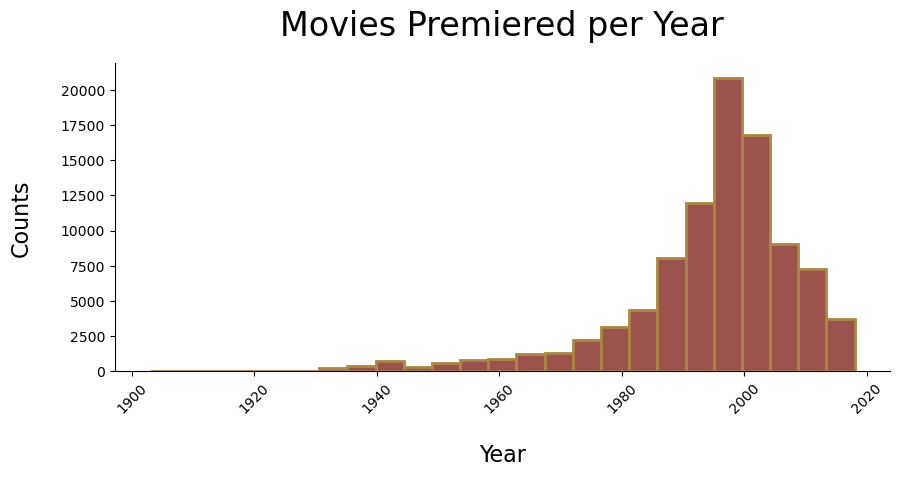

In [27]:
def make_histogram(df, attribute, bins=25, bar_color='#9d534d', edge_color='#ab8742', title='title', xlab='X', ylab='Y', sort_index=False):
    if attribute == 'moviePubYear':
        df = df[df['moviePubYear'] != 9999]
        
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.hist(df[attribute], bins=bins, color=bar_color, ec=edge_color, linewidth=2)
    
    plt.xticks(rotation=45)
    
    
make_histogram(df_complete, 'moviePubYear', title='Movies Premiered per Year', xlab='Year', ylab='Counts')

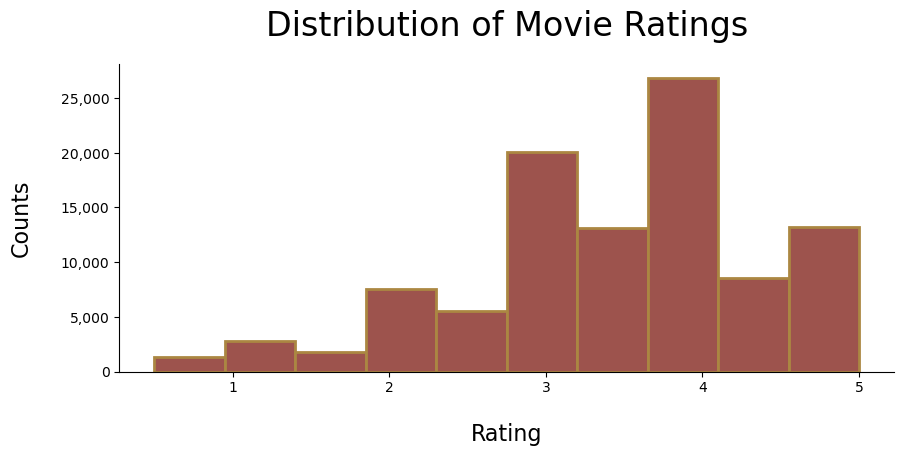

In [68]:
make_histogram(df_complete,'rating', bins = 10, title='Distribution of Movie Ratings', xlab='Rating', ylab='Counts')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('Images/movie_ratings', bbox_inches='tight');

In [36]:
# Split Genres to Graph
genre_df = pd.DataFrame(df_complete['genres'].str.split('|').tolist(), index=df_complete['userId_movieId']).stack()
genre_df = genre_df.reset_index([0, 'userId_movieId'])
genre_df.columns = ['userId_movieId', 'Genre']

,userId_movieId,Genre
0,11,Adventure
1,11,Animation
2,11,Children
3,11,Comedy
4,11,Fantasy
5,51,Adventure
6,51,Animation
7,51,Children
8,51,Comedy
9,51,Fantasy


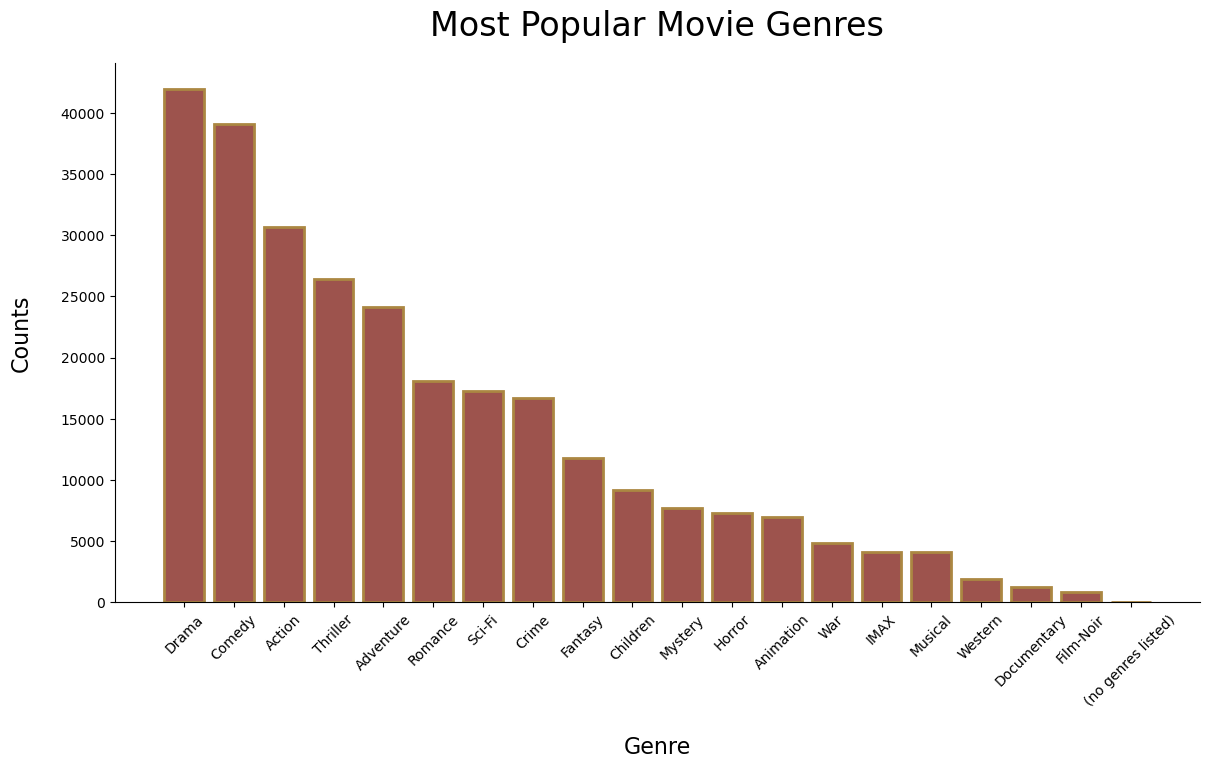

In [37]:
def make_bar_chart(df, attribute, bar_color='#9d534d', edge_color='#ab8742', title='Title', xlab='X', ylab='Y', sort_index=False):
    if sort_index == False:
        xs = df[attribute].value_counts().index
        ys = df[attribute].value_counts().values
    else:
        xs = df[attribute].value_counts().sort_index().index
        ys = df[attribute].value_counts().sort_index().values
        
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=20)
    ax.set_xlabel(xlab, fontsize=16, labelpad=20)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    
    plt.bar(x=xs, height=ys, color=bar_color, edgecolor=edge_color, linewidth=2)
    plt.xticks(rotation=45)
    
    
make_bar_chart(genre_df, 'Genre', title='Most Popular Movie Genres', xlab='Genre', ylab='Counts')

In [100]:
#Code to get Average Ratings for each genre

#First add rating for each user and movie
#using the unique userID and MovieID together we add ratings to our genre dataframe
genre_ratings_df = genre_df.merge(df_complete[['userId_movieId', 'rating']],how = 'left' , on = 'userId_movieId')
#Group by genre and find the mean rating for each
genre_means = genre_ratings_df.groupby('Genre').agg('mean')
#Reset the Index for Graphing
genre_means = genre_means.reset_index([0, 'Genre'])
genre_means

,Genre,rating
0,(no genres listed),3.489362
1,Action,3.448601
2,Adventure,3.509195
3,Animation,3.630475
4,Children,3.415239
5,Comedy,3.385682
6,Crime,3.658946
7,Documentary,3.797785
8,Drama,3.656156
9,Fantasy,3.491174


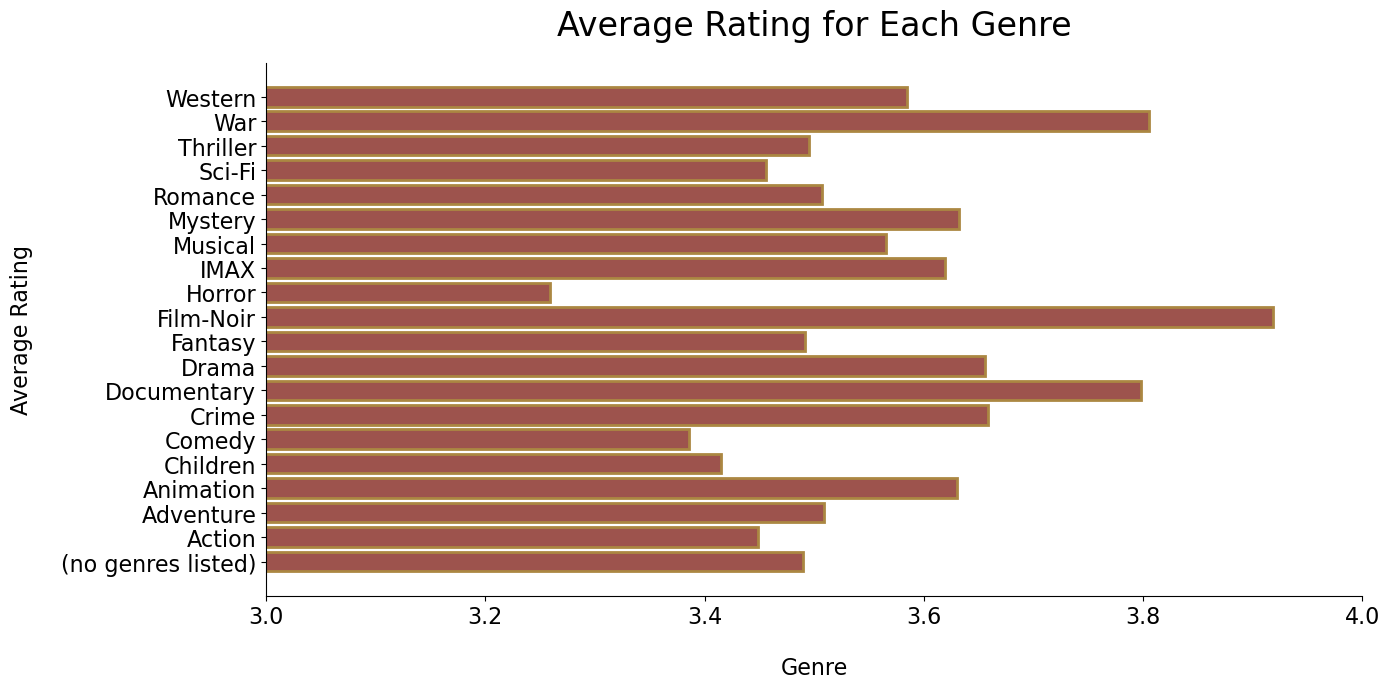

In [119]:
title, xlab, ylab, = 'Average Rating for Each Genre', 'Genre', 'Average Rating'

fig, ax = plt.subplots(figsize=(14, 7))
ax.barh(y = genre_means['Genre'],width = genre_means['rating'], edgecolor='#ab8742', color = '#9d534d', linewidth=2)
plt.xlim([3,4])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(title, fontsize=24, pad=20)
ax.set_xlabel(xlab, fontsize=16, labelpad=20)
ax.set_ylabel(ylab, fontsize=16, labelpad=20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tight_layout()
plt.savefig('Images/genre_ratings_hbar', bbox_inches='tight');
# creating dataframe
  
# plotting a bar graph

    

In [112]:
genre_means['Genre']

0     (no genres listed)
1                 Action
2              Adventure
3              Animation
4               Children
5                 Comedy
6                  Crime
7            Documentary
8                  Drama
9                Fantasy
10             Film-Noir
11                Horror
12                  IMAX
13               Musical
14               Mystery
15               Romance
16                Sci-Fi
17              Thriller
18                   War
19               Western
Name: Genre, dtype: object

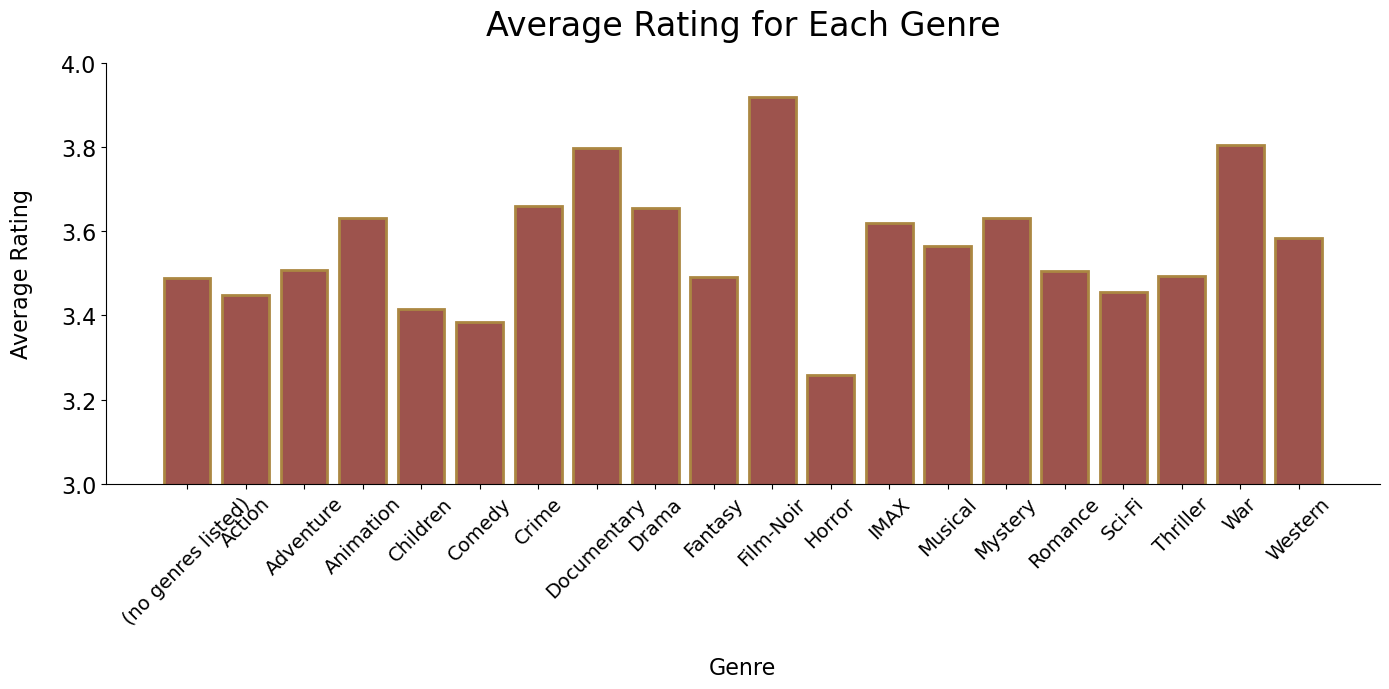

In [120]:
title, xlab, ylab, = 'Average Rating for Each Genre', 'Genre', 'Average Rating'

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(x = genre_means['Genre'] , height = genre_means['rating'], edgecolor='#ab8742', color = '#9d534d', linewidth=2)
plt.ylim([3,4])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(title, fontsize=24, pad=20)
ax.set_xlabel(xlab, fontsize=16, labelpad=20)
ax.set_ylabel(ylab, fontsize=16, labelpad=20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Images/genre_ratings_bar', bbox_inches='tight');

# plotting a bar graph

    

In [ ]:
title, xlab, ylab, = 'Average Rating for Each Genre', 'Genre', 'Average Rating'

fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(title, fontsize=24, pad=20)
ax.set_xlabel(xlab, fontsize=16, labelpad=20)
ax.set_ylabel(ylab, fontsize=16, labelpad=20)
# creating dataframe
ax.bar()
# plotting a bar graph
genre_means.plot(kind="bar")
    

In [31]:
#Graph the number of ratings per movie
num_ratings = pd.DataFrame(df_complete.groupby('movieId').count()['rating']).reset_index()
df_complete = pd.merge(left=df_complete, right=num_ratings, on='movieId')
df_complete.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)

In [32]:
df_complete.sort_values(by='numRatings', ascending=False).drop_duplicates('movieId')

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag,imdbId,tmdbId,moviePubYear,numRatings
2562,251,356,5.0,1470677298,Forrest Gump,Comedy|Drama|Romance|War,1994,NaN,NaN,NaN,109830,13.0,1994,329
16425,250,318,5.0,1121217814,"Shawshank Redemption, The",Crime|Drama,1994,NaN,NaN,NaN,111161,278.0,1994,317
1897,145,296,4.0,832105148,Pulp Fiction,Comedy|Crime|Drama|Thriller,1994,NaN,NaN,NaN,110912,680.0,1994,307
4491,404,593,4.0,838375784,"Silence of the Lambs, The",Crime|Horror|Thriller,1991,NaN,NaN,NaN,102926,274.0,1991,279
12678,77,2571,5.0,1535107478,"Matrix, The",Action|Sci-Fi|Thriller,1999,NaN,NaN,NaN,133093,603.0,1999,278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97656,387,3680,3.0,1148942975,Decline of Western Civilization Part II: The M...,Documentary,1988,NaN,NaN,NaN,94980,36724.0,1988,1
97662,387,3838,2.0,1126494985,Phantasm III: Lord of the Dead,Horror,1994,NaN,NaN,NaN,110823,16139.0,1994,1
93717,217,2056,3.0,955942449,In Search of the Castaways,Adventure|Children,1962,NaN,NaN,NaN,56095,34774.0,1962,1
97667,387,3919,2.5,1129960571,Hellraiser III: Hell on Earth,Horror,1992,NaN,NaN,NaN,104409,11569.0,1992,1


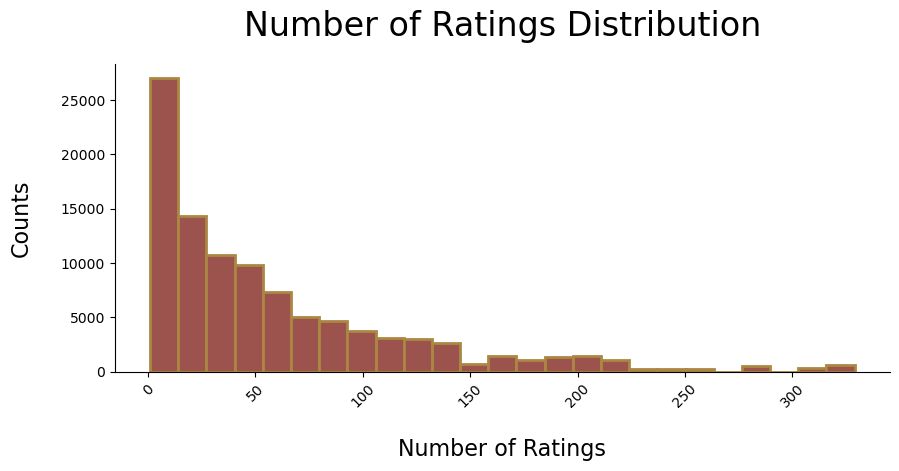

In [33]:
make_histogram(df_complete,'numRatings', bins = 25, title='Number of Ratings Distribution', xlab='Number of Ratings', ylab='Counts')
plt.xticks(rotation=45);

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

In [34]:
df = df_complete

In [35]:
df

,userId,movieId,rating,timestamp_x,title,genres,year,userId_movieId,timestamp_y,tag,imdbId,tmdbId,moviePubYear,numRatings
0,1,1,4.0,964982703,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215
1,5,1,4.0,847434962,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215
2,7,1,4.5,1106635946,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215
3,15,1,2.5,1510577970,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215
4,17,1,4.5,1305696483,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,NaN,NaN,NaN,114709,862.0,1995,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100825,610,160341,2.5,1479545749,Bloodmoon,Action|Thriller,1997,NaN,NaN,NaN,118745,30948.0,1997,1
100826,610,160527,4.5,1479544998,Sympathy for the Underdog,Action|Crime|Drama,1971,NaN,NaN,NaN,66806,90351.0,1971,1
100827,610,160836,3.0,1493844794,Hazard,Action|Drama|Thriller,2005,NaN,NaN,NaN,798722,70193.0,2005,1
100828,610,163937,3.5,1493848789,Blair Witch,Horror|Thriller,2016,NaN,NaN,NaN,1540011,351211.0,2016,1


In [36]:
matrix = df.pivot_table(
    index='userId',
    columns='title',
    values='rating'
)

In [37]:
matrix

title,,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,*batteries not included,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [38]:
def get_similar_movies(movie_title, n_ratings_filter=100, n_recommendations=10):
    similar = matrix.corrwith(matrix[movie_title])
    corr_similar = pd.DataFrame(similar, columns=['correlation'])
    corr_similar.dropna(inplace=True)
    
    orig = df.copy()
    
    corr_with_movie = pd.merge(
        left=corr_similar, 
        right=orig, 
        on='title')[['title', 'correlation', 'numRatings']].drop_duplicates().reset_index(drop=True)
    
    result = corr_with_movie[corr_with_movie['numRatings'] > n_ratings_filter].sort_values(by='correlation', ascending=False)
    
    return result.head(n_recommendations)

In [39]:
get_similar_movies('Pulp Fiction ')

/Users/julietday/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/julietday/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,title,correlation,numRatings
3571,Pulp Fiction,1.000000,307
1540,Fight Club,0.543465,218
2444,Kill Bill: Vol. 1,0.504147,131
4602,Trainspotting,0.437714,102
2445,Kill Bill: Vol. 2,0.421685,110
4717,"Usual Suspects, The",0.411700,204
194,Amelie,0.402193,120
1423,Eternal Sunshine of the Spotless Mind,0.401534,131
3684,Reservoir Dogs,0.394687,131
4653,Twelve Monkeys,0.391141,177


### Train Test Split

In [40]:
data = df[['userId', 'movieId', 'rating']]
data

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5
...,...,...,...
100825,610,160341,2.5
100826,610,160527,4.5
100827,610,160836,3.0
100828,610,163937,3.5


### Convert Pandas Dataframe to Suprise Data format

In [41]:
# Create a dummy reader
reader = Reader(line_format='user item rating', rating_scale=(1, 5))

# Create, a dummy Dataset class
class MyDataset(dataset.DatasetAutoFolds):

    def __init__(self, df, reader):

        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['userId'], df['movieId'], df['rating'])]
        self.reader=reader

data = MyDataset(df, reader)

In [42]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NMF(), KNNBaseline(), KNNBasic(), BaselineOnly()]:
 # Perform cross validation
 results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
 
 # Get results & append algorithm name
 tmp = pd.DataFrame.from_dict(results).mean(axis=0)
 tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split(' ')[-1]], index=['Algorithm']))
 benchmark.append(tmp)
benchmark

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


[test_rmse                                             0.878656
 fit_time                                               3.35765
 test_time                                             0.190225
 Algorithm    <surprise.prediction_algorithms.matrix_factori...
 dtype: object,
 test_rmse                                             0.931601
 fit_time                                               3.53541
 test_time                                             0.112195
 Algorithm    <surprise.prediction_algorithms.matrix_factori...
 dtype: object,
 test_rmse                                            0.881944
 fit_time                                             0.128716
 test_time                                              1.9211
 Algorithm    <surprise.prediction_algorithms.knns.KNNBaseline
 dtype: object,
 test_rmse                                          0.95892
 fit_time                                         0.0404313
 test_time                                          1.32917
 Algorit

In [43]:
train, test = surprise.model_selection.train_test_split(data, random_state=42)

In [44]:
from surprise.prediction_algorithms import NormalPredictor
baseline_model = NormalPredictor()

In [45]:
model_predictions = baseline_model.fit(train).test(test)
baseline_rsme = accuracy.rmse(model_predictions)
baseline_rsme

RMSE: 1.4265


1.4265415593152868

## KNNBasic Algorithm

In [46]:
# train_data = Dataset.load_from_df(data[['user', 'movie', 'rating']], reader = reader)
# trainset = train_data.build_full_trainset()

# param_grid = {'k':[5, 25, 50],'min_k': [1, 5, 10]}
# KNN_model = GridSearchCV(KNNBasic, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# KNN_model.fit(data)

In [47]:
KNN_model.best_params

NameError: name 'KNN_model' is not defined

In [ ]:
# param_grid = {'k':[15, 25, 100],'min_k': [1, 5, 10]}
# KNN_model = GridSearchCV(KNNBasic, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# KNN_model.fit(data)

In [ ]:
KNN_model.best_params

In [ ]:
# param_grid = {'k':[15, 30, 60],'min_k': [1, 5, 10]}
# KNN_model = GridSearchCV(KNNBasic, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# KNN_model.fit(data)

In [ ]:
KNN_model.best_params

In [ ]:
model = KNNBasic(k=15, min_k=5)
model_results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)
model_results

In [ ]:
model_rmse = model_results['test_rmse'].mean()
model_rmse

In [ ]:
model.predict(uid=25, iid=52)

## SVD

In [ ]:
second_model = SVD()

In [ ]:
# param_grid = {'n_factors':[10, 15, 25],
#               'n_epochs': [5, 10, 15], 
#               'lr_all': [0.003, 0.005, 0.007],
#               'reg_all': [0.2, 0.4, 0.6]}
# SVD_optimized = GridSearchCV(SVD, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# SVD_optimized.fit(data)

In [ ]:
SVD_optimized.best_params

In [ ]:
# param_grid = {'n_factors':[25, 30, 50],
#               'n_epochs': [15, 20, 30], 
#               'lr_all': [0.007, 0.009, 0.012],
#               'reg_all': [0.2, 0.8, 1.2]}
# SVD_optimized = GridSearchCV(SVD, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# SVD_optimized.fit(data)

In [ ]:
SVD_optimized.best_params

In [ ]:
model_2 = SVD(n_factors=50, n_epochs=30, lr_all=0.009, reg_all=0.2)
model_2_results = cross_validate(model_2, data, measures=['RMSE'], cv=5, verbose=True)
model_2_results

In [ ]:
model_2_rmse = model_2_results['test_rmse'].mean()
model_2_rmse

## NMF

In [ ]:
third_model = NMF()

In [ ]:
# param_grid = {'n_factors':[10, 15, 25, 30, 50],
#               'n_epochs': [5, 15, 25, 50, 100], 
#               }
# NMF_optimized = GridSearchCV(NMF, param_grid=param_grid, joblib_verbose=5, measures=['RMSE'])
# NMF_optimized.fit(data)

In [ ]:
NMF_optimized.best_params

In [ ]:
model_3 = NMF(n_factors=50, n_epochs=100)
model_3_results = cross_validate(model_3, data, measures=['RMSE'], cv=5, verbose=True)
model_3_results


In [ ]:
model_3_rmse = model_3_results['test_rmse'].mean()
model_3_rmse

## Best Model

In [ ]:
best_model = SVD(n_factors=50, n_epochs=30, lr_all=0.009, reg_all=0.2, random_state=42)
prediction = best_model.fit(train).test(test)
prediction

In [ ]:
accuracy.rmse(prediction)

In [ ]:
# model.get_neighbors(iid=51, k=1)

In [ ]:
# conds = [df['movieId'] == 1, df['movieId'] == 65]
# choices = 2*[True]

# df.loc[np.select(conds, choices, default=False)].sort_values('userId')

## Evaluation and Model Selection

In [ ]:
#Some models are taking too long to run in one cell. SVDpp and Slopeone won't run on my computer
#benchmark = []
# Iterate over all algorithms
#for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(),
 #KNNWithMeans(), KNNWithZScore(), BaselineOnly()]:
 # Perform cross validation
 #results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
 
 # Get results & append algorithm name
 #tmp = pd.DataFrame.from_dict(results).mean(axis=0)
 #tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split(' ')[-1]], index=['Algorithm']))
 #benchmark.append(tmp)

In [ ]:
# benchmark2 = []
# # Iterate over all algorithms
# for algorithm in [KNNWithMeans(), KNNWithZScore()]:
#  # Perform cross validation
#  results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
 
#  # Get results & append algorithm name
#  tmp2 = pd.DataFrame.from_dict(results).mean(axis=0)
#  tmp2 = tmp.append(pd.Series([str(algorithm).split(' ')[0].split(' ')[-1]], index=['Algorithm']))
#  benchmark2.append(tmp)
# benchmark2 

In [ ]:
# trainSet = data.build_full_trainset()

# algo = NormalPredictor()

# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
# model.test(test)

In [ ]:
# surprise.accuracy.mae(model.test(test))

In [ ]:
# surprise.accuracy.mae(model2.test(test))

In [ ]:
# surprise.accuracy.mae(model3.test(test))

In [ ]:
# surprise.accuracy.rmse(model.test(test))

In [ ]:
# surprise.accuracy.rmse(model2.test(test))

In [ ]:
# surprise.accuracy.rmse(model3.test(test))

## How it works for a particular user

In [ ]:
# user_id is the 100
ratings = df.loc[df['userId'] == 100]
# obtain the required data of this user
ratings = ratings[['userId', 'movieId', 'title', 'year' ]]
ratings

In [ ]:
# get the list of the movie ids
unique_ids = df['movieId'].unique()
# get the list of the ids that the userid 100 has watched
iids1001 = df.loc[df['userId']==100, 'movieId']
# remove the rated movies for the recommendations
movies_to_predict = np.setdiff1d(unique_ids,iids1001)

In [ ]:
#Best model based off of crossvalidation
algo = best_model
algo.fit(train)
my_recs = []
for iid in movies_to_predict:
 my_recs.append((iid, algo.predict(uid='100',iid=iid).est))
pred_df = pd.DataFrame(my_recs, columns=['iid', 'predictions']).sort_values('predictions', ascending=False).head(10)
rec_df = movies_df.merge(pred_df, right_on="iid", left_on="movieId", how = "right")
rec_df

In [ ]:
rec_df[['release_year']] = rec_df['year'].str[-4:]
rec_df

In [ ]:
rec_df = rec_df.drop(["iid", "year"], axis = 1)
rec_df = rec_df[['movieId', 'title', 'genres', 'release_year', 'predictions']]
rec_df.head()


In [ ]:
df[df['movieId'] == 1178]